In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, BatchNormalization, Average, Convolution2D, MaxPooling2D, Activation, Embedding
from tensorflow.keras.models import Model, Sequential
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers

from tensorflow.keras import preprocessing

from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

/home/bocharick/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bocharick/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bocharick/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bocharick/anaconda3/lib/python3.7/site-packages/tensorflow/python/f

1.14.0


In [2]:
NUM_WORDS = 30000
MAX_SENTENCE_LEN = 1500
EMBEDDING_VEC_LEN = 320

class_names = ["negative", "positive"]

In [3]:
if tf.__version__.startswith("1."):
    val_acc_name = "val_acc"
    acc_name = "acc"
else:
    val_acc_name = "val_accuracy"
    acc_name = "accuracy"

In [4]:
val_acc_name

'val_acc'

In [5]:
imdb = keras.datasets.imdb

(train_x, train_y), (test_x, test_y) = imdb.load_data(num_words=NUM_WORDS)

train_y = keras.utils.to_categorical(train_y, len(class_names))
test_y = keras.utils.to_categorical(test_y, len(class_names))

In [6]:
train_x.shape

(25000,)

In [7]:
train_y.shape

(25000, 2)

In [8]:
train_x = preprocessing.sequence.pad_sequences(sequences=train_x, maxlen=MAX_SENTENCE_LEN).reshape((len(train_x), MAX_SENTENCE_LEN))
train_x.shape

(25000, 1500)

In [9]:
test_x = preprocessing.sequence.pad_sequences(sequences=test_x, maxlen=MAX_SENTENCE_LEN).reshape((len(test_x), MAX_SENTENCE_LEN))
test_x.shape

(25000, 1500)

In [10]:
train_x[0].shape

(1500,)

In [11]:
train_y[0].shape

(2,)

In [12]:
tf.keras.backend.clear_session()

DROPOUT_RATE = 0.25
DENSE_SIZE = 96

inputs = Input(shape=(MAX_SENTENCE_LEN), name="Input")
embed = Embedding(input_dim=NUM_WORDS, output_dim=EMBEDDING_VEC_LEN, input_length=MAX_SENTENCE_LEN)(inputs)
flat = Flatten()(embed)

h_1 = Dense(DENSE_SIZE, activation='relu', name="hidden_1")(flat)
drop_1 = Dropout(DROPOUT_RATE, name="dropout_1")(h_1)

h_2 = Dense(DENSE_SIZE, activation='relu', name="hidden_2")(drop_1)
drop_2 = Dropout(DROPOUT_RATE, name="dropout_2")(h_2)

predictions = Dense(len(class_names), activation='softmax', name="Output")(drop_2)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 1500)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1500, 320)         9600000   
_________________________________________________________________
flatten (Flatten)            (None, 480000)            0         
_________________________________________________________________
hidden_1 (Dense)             (None, 96)                46080096  
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_______________________

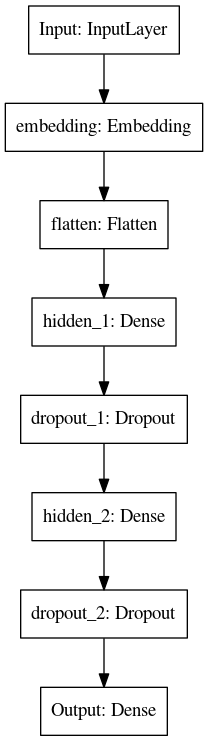

In [13]:
plot_model(model)

In [14]:
checkpoint = ModelCheckpoint('imdb_base.hdf5',
                            monitor=val_acc_name,
                            save_best_only=True,
                            period=5,
                            verbose=1)
early_stopping_callback = EarlyStopping(monitor=val_acc_name, 
                                        min_delta=1e-9, 
                                        patience=50, 
                                        verbose=1, 
                                        mode='auto', 
                                        baseline=None, 
                                        restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor=val_acc_name,
                                           patience=5,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00000001)

In [15]:
%%time
BATCH_SIZE = 256
EPOCHS = 10000000000
history = model.fit(x=train_x, y=train_y, batch_size=BATCH_SIZE,
                   epochs = EPOCHS,
                   validation_data=(test_x, test_y),
                   verbose=1,
                   callbacks=[checkpoint, learning_rate_reduction, early_stopping_callback])

Train on 25000 samples, validate on 25000 samples
Epoch 1/10000000000
25000/25000 [==============================] - 8s 302us/sample - loss: 1.1212 - acc: 0.5022 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/10000000000
25000/25000 [==============================] - 7s 292us/sample - loss: 0.6928 - acc: 0.4971 - val_loss: 0.6931 - val_acc: 0.5002
Epoch 3/10000000000
25000/25000 [==============================] - 7s 284us/sample - loss: 0.6923 - acc: 0.4996 - val_loss: 0.6930 - val_acc: 0.5012
Epoch 4/10000000000
25000/25000 [==============================] - 7s 293us/sample - loss: 0.6905 - acc: 0.5040 - val_loss: 0.6897 - val_acc: 0.5026
Epoch 5/10000000000
24832/25000 [============================>.] - ETA: 0s - loss: 0.5317 - acc: 0.7326
Epoch 00005: val_acc improved from -inf to 0.87548, saving model to imdb_base.hdf5
25000/25000 [==============================] - 13s 507us/sample - loss: 0.5306 - acc: 0.7335 - val_loss: 0.3005 - val_acc: 0.8755
Epoch 6/10000000000
25000/25000 [====

Epoch 41/10000000000
24832/25000 [============================>.] - ETA: 0s - loss: 6.4814e-05 - acc: 1.0000
Epoch 00041: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
25000/25000 [==============================] - 7s 296us/sample - loss: 6.7054e-05 - acc: 1.0000 - val_loss: 1.1311 - val_acc: 0.8753
Epoch 42/10000000000
25000/25000 [==============================] - 7s 294us/sample - loss: 3.1778e-05 - acc: 1.0000 - val_loss: 1.1360 - val_acc: 0.8754
Epoch 43/10000000000
25000/25000 [==============================] - 7s 287us/sample - loss: 4.9055e-05 - acc: 1.0000 - val_loss: 1.1419 - val_acc: 0.8754
Epoch 44/10000000000
25000/25000 [==============================] - 7s 287us/sample - loss: 6.3059e-05 - acc: 1.0000 - val_loss: 1.1443 - val_acc: 0.8752
Epoch 45/10000000000
24832/25000 [============================>.] - ETA: 0s - loss: 5.2034e-05 - acc: 1.0000
Epoch 00045: val_acc did not improve from 0.87576
25000/25000 [==============================] - 7s 293us/s

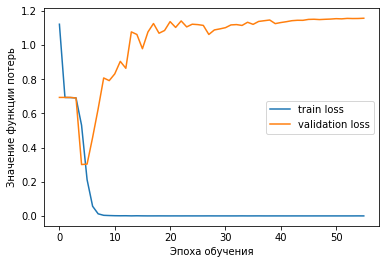

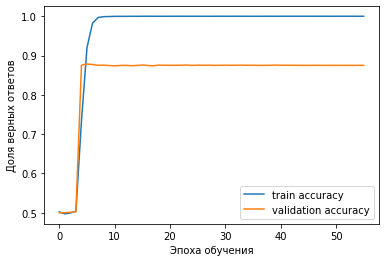

In [16]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history[acc_name], label='train accuracy')
plt.plot(history.history[val_acc_name], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

In [17]:
model.evaluate(test_x, test_y)

25000/25000 [==============================] - 2s 96us/sample - loss: 0.3032 - acc: 0.8785


[0.30320246502399445, 0.87852]

In [18]:
preds = model.predict(test_x)

print("Test data evaluation:")
print(classification_report(test_y.argmax(axis=1), preds.argmax(axis=1), target_names=class_names))

Test data evaluation:
              precision    recall  f1-score   support

    negative       0.87      0.90      0.88     12500
    positive       0.89      0.86      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

